# 02 – Evaluation Plots: ROC & Confusion Matrix
Recreate split, plot ROC (test) and Confusion Matrix (test).

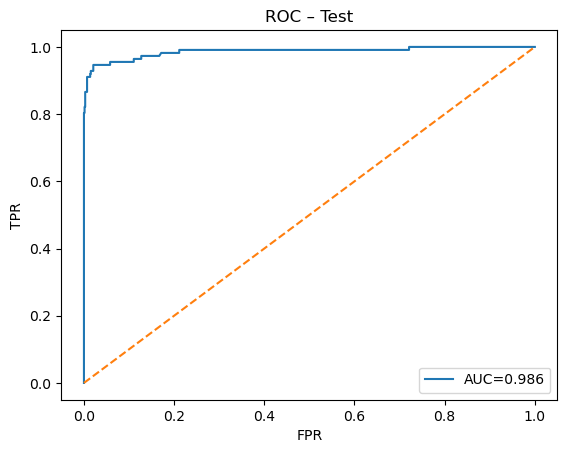

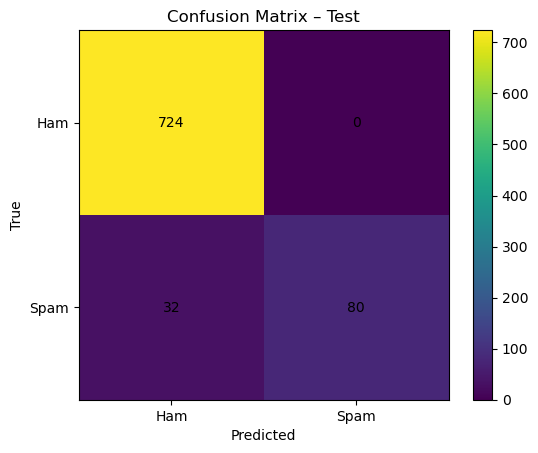

In [1]:
import os, numpy as np, pandas as pd, joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
data_path = '../data/raw/SMSSpamCollection'
model_dir = '../models/latest'
def load_dataset(path):
    try:
        df = pd.read_csv(path, sep='\t', header=None, names=['label','text'], encoding='utf-8')
    except Exception:
        tmp = pd.read_csv(path, encoding='utf-8', engine='python')
        cols = {c.lower(): c for c in tmp.columns}
        label_col = next((cols[c] for c in ['label','class','target','v1'] if c in cols), None)
        text_col  = next((cols[c] for c in ['text','message','sms','v2'] if c in cols), None)
        df = tmp[[label_col, text_col]].rename(columns={label_col:'label', text_col:'text'})
    df = df.dropna(subset=['label','text']).copy()
    df['label'] = (df['label'].astype(str).str.strip().str.lower()
                   .map({'ham':0,'spam':1,'0':0,'1':1}).fillna(df['label']))
    if df['label'].dtype == 'O':
        df['label'] = pd.factorize(df['label'])[0]
    df['text'] = df['text'].astype(str)
    return df[['text','label']]
df = load_dataset(data_path)
X, y = df['text'].values, df['label'].values
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
val_rel = 0.15 / (1.0 - 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_rel, random_state=42, stratify=y_trainval)
pipe = joblib.load(os.path.join(model_dir, 'model.joblib'))
y_prob = pipe.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(); plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC – Test'); plt.legend(loc='lower right'); os.makedirs('../reports/figures', exist_ok=True); plt.savefig('../reports/figures/roc_test.png', dpi=160, bbox_inches='tight'); plt.show()
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(); im = plt.imshow(cm, interpolation='nearest'); plt.title('Confusion Matrix – Test'); plt.colorbar(im); plt.xticks([0,1], ['Ham','Spam']); plt.yticks([0,1], ['Ham','Spam']);
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.savefig('../reports/figures/confusion_matrix_test.png', dpi=160, bbox_inches='tight'); plt.show()
